# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [1]:
# import libraries
from pyspark.sql import SparkSession, Window
from pyspark.sql.functions import avg, stddev, split, udf, isnull, first, col, format_number
from pyspark.sql.functions import min as fmin
from pyspark.sql.functions import max as fmax
from pyspark.sql.types import IntegerType, FloatType

from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression, DecisionTreeClassifier,RandomForestClassifier, GBTClassifier
from pyspark.ml.feature import StandardScaler, VectorAssembler
from pyspark.ml.evaluation import MulticlassClassificationEvaluator,BinaryClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

In [33]:
import re
import copy
import time
import datetime
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline

In [3]:
#set seaborn style
sns.set(style="whitegrid")

In [4]:
# create a Spark session
spark = SparkSession.builder.appName('Sparkify_local').getOrCreate()

# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

## Scan Data

In [5]:
df = spark.read.json('mini_sparkify_event_data.json')
df.show(1)

+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|        artist|     auth|firstName|gender|itemInSession|lastName|   length|level|       location|method|    page| registration|sessionId|     song|status|           ts|           userAgent|userId|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
|Martha Tilston|Logged In|    Colin|     M|           50| Freeman|277.89016| paid|Bakersfield, CA|   PUT|NextSong|1538173362000|       29|Rockpools|   200|1538352117000|Mozilla/5.0 (Wind...|    30|
+--------------+---------+---------+------+-------------+--------+---------+-----+---------------+------+--------+-------------+---------+---------+------+-------------+--------------------+------+
only showi

In [5]:
df.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)



In [8]:
df.describe('userId').show()

+-------+-----------------+
|summary|           userId|
+-------+-----------------+
|  count|           286500|
|   mean|59682.02278593872|
| stddev|109091.9499991047|
|    min|                 |
|    max|               99|
+-------+-----------------+



In [9]:
df.describe('sessionId').show()

+-------+-----------------+
|summary|        sessionId|
+-------+-----------------+
|  count|           286500|
|   mean|1041.526554973822|
| stddev|726.7762634630741|
|    min|                1|
|    max|             2474|
+-------+-----------------+



In [10]:
df.count()

286500

## Clean Data

- Drop NaN and ''

In [13]:
df.filter(isnull(df['userId'])).count()

0

In [14]:
df.filter(isnull(df['sessionId'])).count()

0

In [15]:
df.filter(df['userId']=='').count()

8346

In [16]:
df.filter(df['sessionId']=='').count()

0

In [6]:
df_cleaned = df.filter(df['userId']!='')

- correct the dtype (datetime)

In [7]:
# Create a user defined function for formating the timestamp
get_time = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime("%Y-%m-%d %H:%M:%S"))

#Apply the udf on the ts column
df_cleaned = df_cleaned.withColumn("time", get_time(df_cleaned.ts))

In [8]:
df_cleaned.take(1)

[Row(artist='Martha Tilston', auth='Logged In', firstName='Colin', gender='M', itemInSession=50, lastName='Freeman', length=277.89016, level='paid', location='Bakersfield, CA', method='PUT', page='NextSong', registration=1538173362000, sessionId=29, song='Rockpools', status=200, ts=1538352117000, userAgent='Mozilla/5.0 (Windows NT 6.1; WOW64; rv:31.0) Gecko/20100101 Firefox/31.0', userId='30', time='2018-10-01 00:01:57')]

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.


In [9]:
#try sparksql
#Create a temporary view to perform SQL operations
df_cleaned.createOrReplaceTempView("Sparkify_local_cleaned")

- auth

In [38]:
spark.sql('''
        SELECT DISTINCT(auth)
        FROM Sparkify_local_cleaned
''').show()

+---------+
|     auth|
+---------+
|Cancelled|
|Logged In|
+---------+



In [40]:
spark.sql('''
        SELECT auth,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY auth
        ORDER BY user_counts DESC
''').show()

+---------+-----------+
|     auth|user_counts|
+---------+-----------+
|Logged In|        225|
|Cancelled|         52|
+---------+-----------+



There are 52 users have Cancelled.

- gender

In [41]:
gender_count = spark.sql('''
        SELECT gender,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY gender
        ORDER BY user_counts DESC
''')
gender_count.show()

+------+-----------+
|gender|user_counts|
+------+-----------+
|     M|        121|
|     F|        104|
+------+-----------+



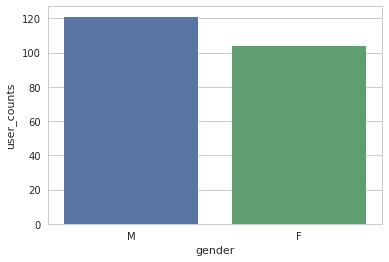

In [45]:
sns.barplot(x='gender',y='user_counts',data=gender_count.toPandas());

There are 121 males and 104 females in this dataset.

- itemInSession

In [47]:
spark.sql('''
        SELECT COUNT(DISTINCT(itemInSession)) AS item_counts
        FROM Sparkify_local_cleaned
''').show()

+-----------+
|item_counts|
+-----------+
|       1311|
+-----------+



- length

In [10]:
length_data = spark.sql('''
        SELECT length
        FROM Sparkify_local_cleaned
''')

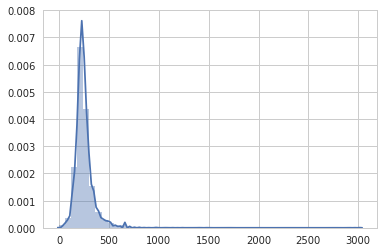

In [16]:
sns.distplot(length_data.toPandas().dropna());

Most of length are between 0 and 500.

- level

In [17]:
spark.sql('''
        SELECT level,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY level
        ORDER BY user_counts DESC
''').show()

+-----+-----------+
|level|user_counts|
+-----+-----------+
| free|        195|
| paid|        165|
+-----+-----------+



There are 195 free and 165 paid account in this dataset, in another word, there are 135 users have changed their account level.

- location

In [12]:
location_count = spark.sql('''
        SELECT location,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY location
        ORDER BY user_counts DESC
''').toPandas()

In [17]:
#split city and state
location_count = location_count.join(location_count['location'].str.split(',',expand=True).rename(columns={0:'city',1:'state'})).drop('location',axis=1)

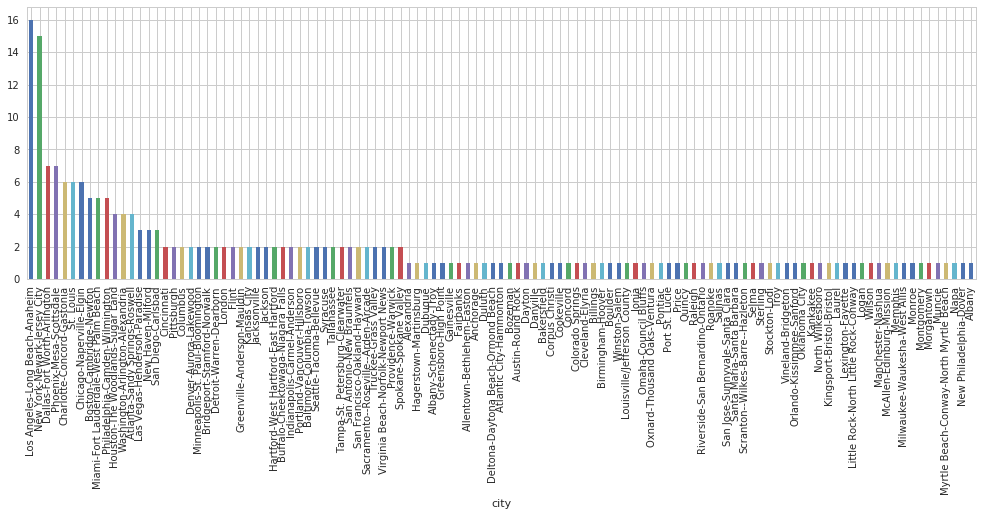

In [24]:
location_count.groupby('city')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

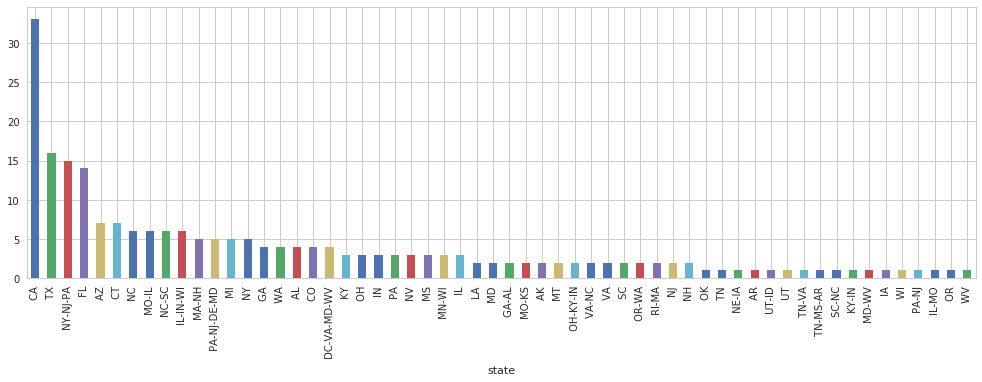

In [25]:
location_count.groupby('state')['user_counts'].sum().sort_values(ascending=False).plot(kind='bar',figsize=(17,5));

Los Angeles and New York are top cities which have the largest user count, and California is the top state has the largest user count.

- page

In [27]:
spark.sql('''
        SELECT page,COUNT(userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY page
        ORDER BY user_counts DESC
''').show()

+--------------------+-----------+
|                page|user_counts|
+--------------------+-----------+
|            NextSong|     228108|
|           Thumbs Up|      12551|
|                Home|      10082|
|     Add to Playlist|       6526|
|          Add Friend|       4277|
|         Roll Advert|       3933|
|              Logout|       3226|
|         Thumbs Down|       2546|
|           Downgrade|       2055|
|            Settings|       1514|
|                Help|       1454|
|             Upgrade|        499|
|               About|        495|
|       Save Settings|        310|
|               Error|        252|
|      Submit Upgrade|        159|
|    Submit Downgrade|         63|
|              Cancel|         52|
|Cancellation Conf...|         52|
+--------------------+-----------+



- userAgent

In [28]:
userAgent_count = spark.sql('''
        SELECT userAgent,COUNT(DISTINCT userId) AS user_counts
        FROM Sparkify_local_cleaned
        GROUP BY userAgent
        ORDER BY user_counts DESC
''').toPandas()

In [8]:
def get_browser(x):
    if 'Firefox' in x:
        return 'Firefox'
    elif 'Safari' in x:
        if 'Chrome' in x:
            return 'Chrome'
        else:
            return 'Safari'
    elif 'Trident' in x:
        return 'IE'
    else:
        return np.NaN

In [30]:
userAgent_count['browser'] = userAgent_count['userAgent'].apply(get_browser)

In [9]:
platform_dict = {'compatible': 'Windows',  'iPad': 'iPad',  'iPhone': 'iPhone',  
          'Macintosh': 'Mac',  'Windows NT 5.1': 'Windows','Windows NT 6.0': 'Windows', 'Windows NT 6.1': 'Windows',  
          'Windows NT 6.2': 'Windows',  'Windows NT 6.3': 'Windows', 'X11': 'Linux'}

In [32]:
userAgent_count['platform'] = userAgent_count['userAgent'].str.extract(r'\(([^\)]*)\)')[0].str.split(';').str[0].map(platform_dict)

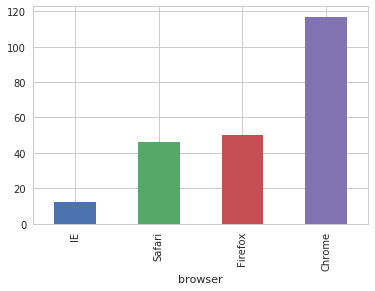

In [33]:
userAgent_count.groupby('browser')['user_counts'].sum().sort_values().plot(kind='bar');

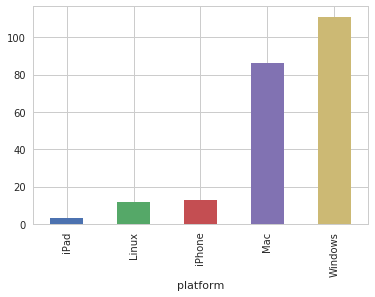

In [58]:
userAgent_count.groupby('platform')['user_counts'].sum().sort_values().plot(kind='bar');

- time

In [64]:
time_data = spark.sql('''
        SELECT time,userId
        FROM Sparkify_local_cleaned
''').toPandas()

In [70]:
time_data['time'] = pd.to_datetime(time_data['time'])

In [80]:
weekday_dict = {0:'Mon.',1:'Tues.',2:'Wed.',3:'Thur.',4:'Fri.',5:'Sat.',6:'Sun.'}
time_data['weekday'] = time_data['time'].dt.weekday.map(weekday_dict)
time_data['day'] = time_data['time'].dt.day
time_data['hour'] = time_data['time'].dt.hour

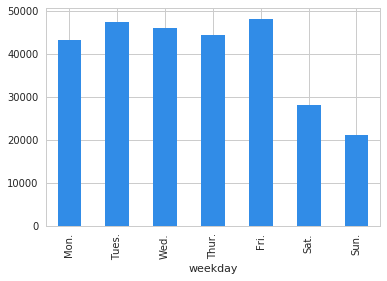

In [93]:
time_data.groupby('weekday')['userId'].count().loc[list(weekday_dict.values())].plot(kind='bar',color='#318ce7');

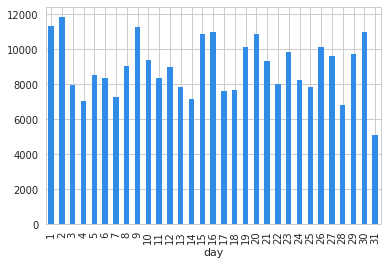

In [94]:
time_data.groupby('day')['userId'].count().plot(kind='bar',color='#318ce7');

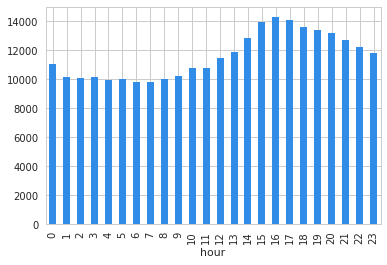

In [95]:
time_data.groupby('hour')['userId'].count().plot(kind='bar',color='#318ce7');

Users' behaviors are periodic, they use Sparkify more offten in workdays than weekend; In one single day, they use Sparkify more often after 14 o'clock.


### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [8]:
#first we should define a column named Churn as dataset's label for predict
#find the flag event
df_cleaned.select('page').dropDuplicates().collect()

[Row(page='Cancel'),
 Row(page='Submit Downgrade'),
 Row(page='Thumbs Down'),
 Row(page='Home'),
 Row(page='Downgrade'),
 Row(page='Roll Advert'),
 Row(page='Logout'),
 Row(page='Save Settings'),
 Row(page='Cancellation Confirmation'),
 Row(page='About'),
 Row(page='Settings'),
 Row(page='Add to Playlist'),
 Row(page='Add Friend'),
 Row(page='NextSong'),
 Row(page='Thumbs Up'),
 Row(page='Help'),
 Row(page='Upgrade'),
 Row(page='Error'),
 Row(page='Submit Upgrade')]

In [10]:
#define the flag event udf to transform event to 0 or 1
flag_event = udf(lambda x : 1 if x=='Cancellation Confirmation' else 0, IntegerType())

In [11]:
#define the current churn or not state
df_cleaned_cancel = df_cleaned.withColumn('Churn_state',flag_event('page'))

In [12]:
#mark the user who have churned event
userwindow = Window.partitionBy('userId').rangeBetween(Window.unboundedPreceding,Window.unboundedFollowing)
df_cleaned_cancel = df_cleaned_cancel.withColumn('Churn',fmax('Churn_state').over(userwindow))

In [15]:
df_cleaned_cancel.take(1)

[Row(artist='Sleeping With Sirens', auth='Logged In', firstName='Darianna', gender='F', itemInSession=0, lastName='Carpenter', length=202.97098, level='free', location='Bridgeport-Stamford-Norwalk, CT', method='PUT', page='NextSong', registration=1538016340000, sessionId=31, song='Captain Tyin Knots VS Mr Walkway (No Way)', status=200, ts=1539003534000, userAgent='"Mozilla/5.0 (iPhone; CPU iPhone OS 7_1_2 like Mac OS X) AppleWebKit/537.51.2 (KHTML, like Gecko) Version/7.0 Mobile/11D257 Safari/9537.53"', userId='100010', time='2018-10-08 12:58:54', Churn_state=0, Churn=0)]

In [14]:
df_cleaned_cancel.dropDuplicates(['userId']).select('Churn').groupby('Churn').count().collect()

[Row(Churn=1, count=52), Row(Churn=0, count=173)]

So, there are 52 users have churned events in the dataset, it's about 23.1% churned rate.

Check differences in each feature between two stage of Churn.

- auth

In [18]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["Churn", "auth"]).count().sort("Churn").show()

+-----+---------+-----+
|Churn|     auth|count|
+-----+---------+-----+
|    0|Logged In|  173|
|    1|Logged In|   52|
+-----+---------+-----+



so,the `auth` has no effect on Churn or not.

- gender

In [17]:
df_cleaned_cancel.dropDuplicates(["userId", "gender"]).groupby(["Churn", "gender"]).count().sort("Churn").show()

+-----+------+-----+
|Churn|gender|count|
+-----+------+-----+
|    0|     M|   89|
|    0|     F|   84|
|    1|     F|   20|
|    1|     M|   32|
+-----+------+-----+



In [32]:
proportions_ztest([32,20],[121,104],alternative='two-sided')

(1.2800974409737422, 0.20051086855629463)

In males, churn rate is 0.264 which is 0.192 in females, but the p-value is 0.2 over 0.05, so the gender has almost no effect on Churn or not.

- length

In [35]:
df_cleaned_cancel.select(["Churn", "length"]).groupby(["Churn"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length')).show()

+-----+------------------+------------------+----------+----------+
|Churn|       mean_length|      stdev_length|max_length|min_length|
+-----+------------------+------------------+----------+----------+
|    1|248.63279564406218|102.38497717575477|3024.66567|   4.04853|
|    0|249.20913538880816|  98.6258830014688|3024.66567|   0.78322|
+-----+------------------+------------------+----------+----------+



- level

In [36]:
df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["Churn", "level"]).count().sort("Churn").show()

+-----+-----+-----+
|Churn|level|count|
+-----+-----+-----+
|    0| free|  133|
|    0| paid|   40|
|    1| paid|    8|
|    1| free|   44|
+-----+-----+-----+



In [37]:
proportions_ztest([8,44],[48,177],alternative='two-sided')

(-1.194176507959015, 0.23240893045643263)

- location

In [13]:
def normalize_data(groupby_data):
    groupby_series = groupby_data.set_index(list(groupby_data.columns[:2]))
    temp = groupby_series.unstack('Churn').fillna(0)
    df = pd.DataFrame(((temp - temp.min()) / (temp.max() - temp.min())).stack()).reset_index()
    df = df.rename(columns={df.columns[-1]:'result'})
    return df

In [14]:
# source: https://stackoverflow.com/questions/39235704/split-spark-dataframe-string-column-into-multiple-columns
split_city_state = split(df_cleaned_cancel['location'], ',')
df_cleaned_cancel = df_cleaned_cancel.withColumn('city',split_city_state.getItem(0))
df_cleaned_cancel = df_cleaned_cancel.withColumn('state',split_city_state.getItem(1))

In [18]:
city_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["city","Churn"]).count().sort("city").toPandas()

In [19]:
city_data = normalize_data(city_data)

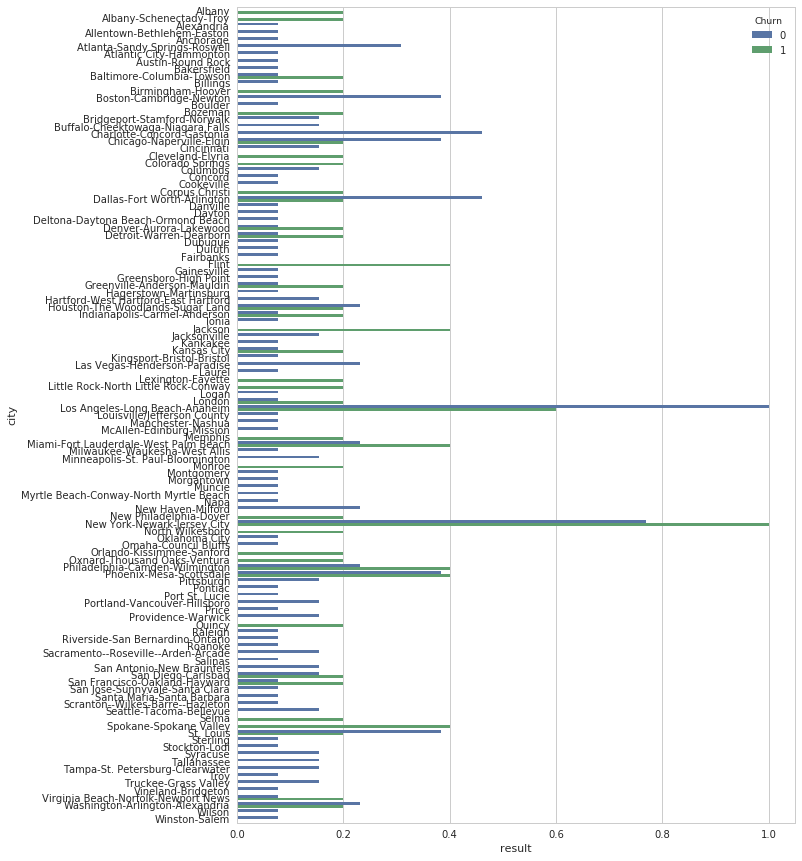

In [20]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="result",y="city", hue="Churn", data=city_data,ax=ax);

In [179]:
state_data = df_cleaned_cancel.dropDuplicates(["userId"]).groupby(["state","Churn"]).count().sort("state").toPandas()

In [180]:
state_data = normalize_data(state_data)

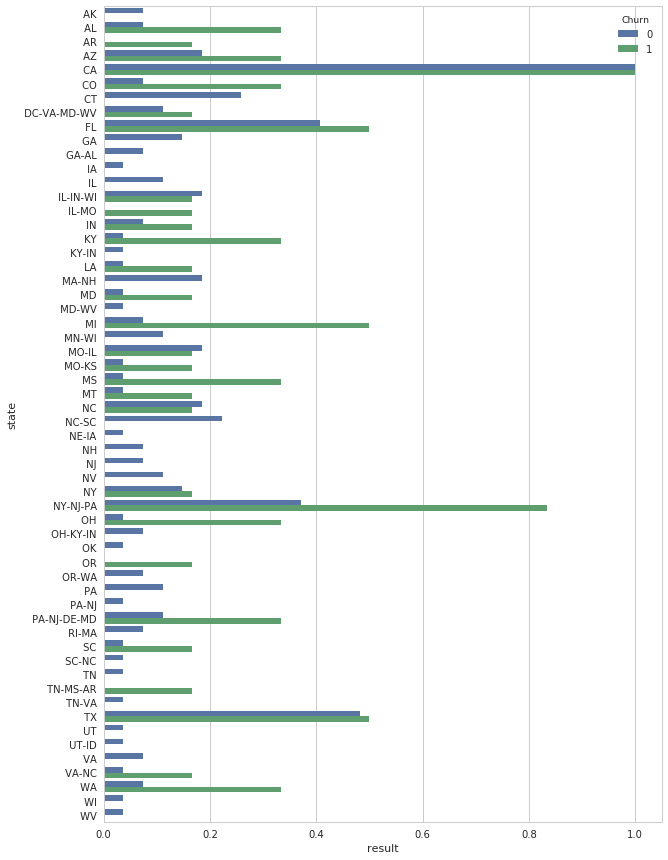

In [181]:
fig, ax = plt.subplots(figsize=(10,15))
sns.barplot( x="result",y="state", hue="Churn", data=state_data,ax=ax);

- page

In [73]:
df_cleaned_cancel.select(["Churn", "page"]).groupby(["Churn", "page"]).count().sort("page").show()

+-----+--------------------+------+
|Churn|                page| count|
+-----+--------------------+------+
|    1|               About|    56|
|    0|               About|   439|
|    1|          Add Friend|   636|
|    0|          Add Friend|  3641|
|    1|     Add to Playlist|  1038|
|    0|     Add to Playlist|  5488|
|    1|              Cancel|    52|
|    1|Cancellation Conf...|    52|
|    0|           Downgrade|  1718|
|    1|           Downgrade|   337|
|    0|               Error|   220|
|    1|               Error|    32|
|    0|                Help|  1215|
|    1|                Help|   239|
|    0|                Home|  8410|
|    1|                Home|  1672|
|    1|              Logout|   553|
|    0|              Logout|  2673|
|    1|            NextSong| 36394|
|    0|            NextSong|191714|
+-----+--------------------+------+
only showing top 20 rows



In [184]:
page_data = df_cleaned_cancel.select(["page","Churn"]).groupby([ "page","Churn"]).count().sort("page").toPandas()

In [185]:
page_data = normalize_data(page_data)

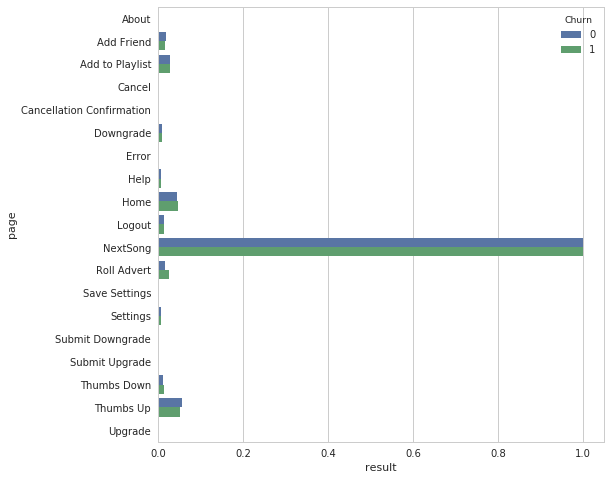

In [188]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="page", hue="Churn", data=page_data,ax=ax);

Page NextSong,Thumbs Up/Down, Home, Add to Playlist seems have effect on Churn or not.

- userAgent

In [15]:
browser = udf(lambda x : get_browser(x))

In [16]:
#get browsers
df_cleaned_cancel = df_cleaned_cancel.withColumn('browser',browser(df_cleaned_cancel.userAgent))

In [17]:
get_platform = udf(lambda x: platform_dict[re.findall(r'\(([^\)]*)\)',x)[0].split(';')[0]])

In [18]:
#get platform
df_cleaned_cancel = df_cleaned_cancel.withColumn('platform',get_platform(df_cleaned_cancel.userAgent))

In [24]:
browser_data = df_cleaned_cancel.select(["browser","Churn"]).groupby([ "browser","Churn"]).count().sort("browser").toPandas()

In [25]:
browser_data = normalize_data(browser_data)

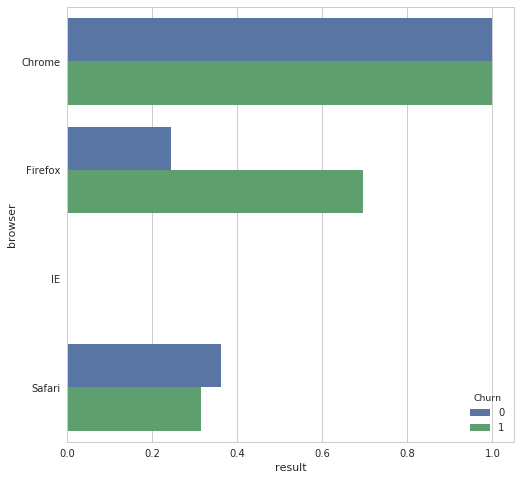

In [26]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="browser", hue="Churn", data=browser_data,ax=ax);

In [215]:
platform_data = df_cleaned_cancel.select(["platform","Churn"]).groupby([ "platform","Churn"]).count().sort("platform").toPandas()

In [216]:
platform_data = normalize_data(platform_data)

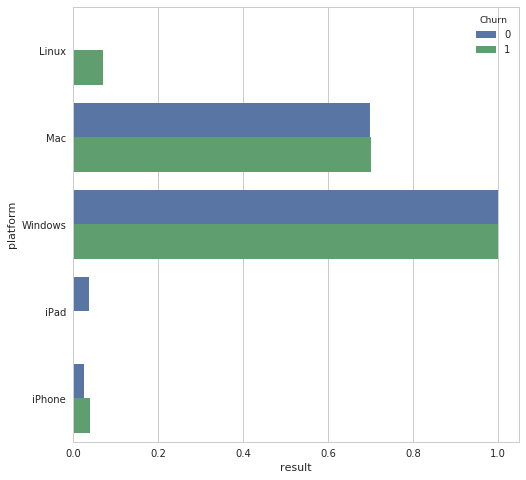

In [217]:
fig, ax = plt.subplots(figsize=(8,8))
sns.barplot( x="result",y="platform", hue="Churn", data=platform_data,ax=ax);

- time

In [19]:
get_hour = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).hour)
get_day = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).day)
get_weekday = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0).strftime('%w'))

In [20]:
df_cleaned_cancel = df_cleaned_cancel.withColumn('hour', get_hour(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn('day', get_day(df_cleaned_cancel.ts))
df_cleaned_cancel = df_cleaned_cancel.withColumn('dayofweek', get_weekday(df_cleaned_cancel.ts))

In [189]:
hour_data = df_cleaned_cancel.select(["Churn", "hour"]).groupby(["Churn", "hour"]).count().sort("hour").toPandas()
day_data = df_cleaned_cancel.select(["Churn", "day"]).groupby(["Churn", "day"]).count().sort("day").toPandas()
dayofweek_data = df_cleaned_cancel.select(["Churn", "dayofweek"]).groupby(["Churn", "dayofweek"]).count().sort("dayofweek").toPandas()

In [190]:
hour_data = normalize_data(hour_data)

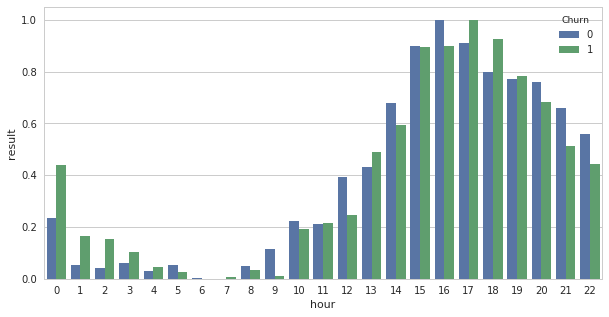

In [191]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="hour",y="result", hue="Churn", data=hour_data,ax=ax,order=list(map(lambda x: str(x),range(23))));

In [192]:
day_data = normalize_data(day_data)

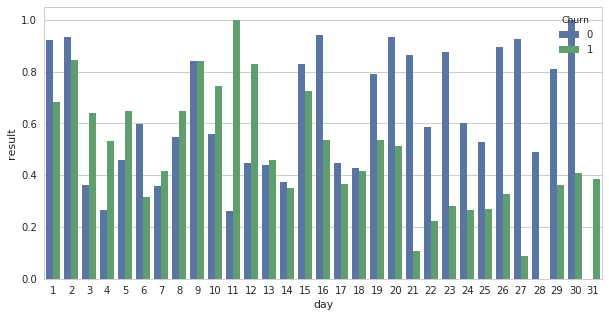

In [193]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="day",y="result", hue="Churn", data=day_data,ax=ax,order=list(map(lambda x: str(x),range(1,32))));

In [194]:
dayofweek_data = normalize_data(dayofweek_data)

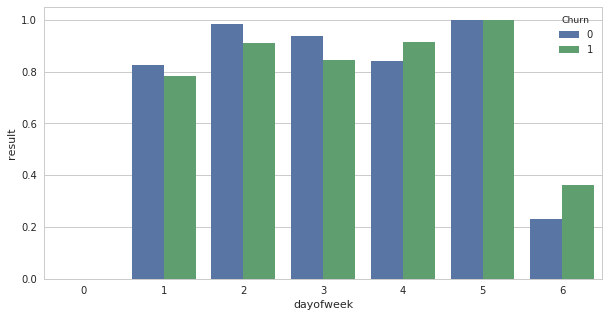

In [195]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot( x="dayofweek",y="result", hue="Churn", data=dayofweek_data,ax=ax);

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [21]:
df_cleaned_cancel.printSchema()

root
 |-- artist: string (nullable = true)
 |-- auth: string (nullable = true)
 |-- firstName: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- itemInSession: long (nullable = true)
 |-- lastName: string (nullable = true)
 |-- length: double (nullable = true)
 |-- level: string (nullable = true)
 |-- location: string (nullable = true)
 |-- method: string (nullable = true)
 |-- page: string (nullable = true)
 |-- registration: long (nullable = true)
 |-- sessionId: long (nullable = true)
 |-- song: string (nullable = true)
 |-- status: long (nullable = true)
 |-- ts: long (nullable = true)
 |-- userAgent: string (nullable = true)
 |-- userId: string (nullable = true)
 |-- time: string (nullable = true)
 |-- Churn_state: integer (nullable = true)
 |-- Churn: integer (nullable = true)
 |-- city: string (nullable = true)
 |-- state: string (nullable = true)
 |-- browser: string (nullable = true)
 |-- platform: string (nullable = true)
 |-- hour: string (nullable = true)


On the basis of the above EDA, we can create features as follows:
- Categorical Features (need label encoding)
    - gender
    - level
    - browser
    - platform
- Numerical Features
    - mean,max,min,std of length of users
    - numbers of each item in page (ThumbsUp ...
    - number of unique songs and total songs of users
    - number of unique artists of users
    - percentage of operations after 15th in a month
    - percentage of operations in workday

- Categorical Features

In [22]:
def label_encoding(col_name):
    '''
    transform categorical items to number
    '''
    temp = df_cleaned_cancel.select([col_name]).dropDuplicates().toPandas()
#     print(temp)
    label_dict = {val:str(idx) for idx,val in enumerate(temp[col_name].tolist())}
    result = df_cleaned_cancel.dropDuplicates(['userId']).select(['userId',col_name]).replace(label_dict,subset=col_name)
    return result

In [23]:
def get_categorical_features():
    '''
    join all categorical features together
    '''
    feature_gender = label_encoding('gender')
    feature_level = label_encoding('level')
    feature_browser = label_encoding('browser')
    feature_platform = label_encoding('platform')
    
    result = feature_gender.join(feature_level,on='userId',how='inner').\
                            join(feature_browser,on='userId',how='inner').\
                            join(feature_platform,on='userId',how='inner')
    return result

In [32]:
categorical_feature = get_categorical_features()

In [33]:
categorical_feature.show(2)

+------+------+-----+-------+--------+
|userId|gender|level|browser|platform|
+------+------+-----+-------+--------+
|100010|     0|    0|      1|       1|
|200002|     1|    0|      1|       1|
+------+------+-----+-------+--------+
only showing top 2 rows



- Numerical Features

In [24]:
def get_numerical_features():
    '''
    join all numerical features together and implement Standscaler
    '''
    #length
    feature_length = df_cleaned_cancel.select(["userId", "length"]).groupby(["userId"]).agg(avg('length').alias('mean_length'), 
                                                                     stddev('length').alias('stdev_length'),
                                                                    fmax('length').alias('max_length'),
                                                                    fmin('length').alias('min_length'))
    
    #page, reference url:https://stackoverflow.com/questions/56051438/pivot-table-in-pyspark
    page_count = df_cleaned_cancel.select(["userId","page"]).groupby(["userId","page"]).count()
    # create the pivot table
    temp1 = page_count.groupby('userId').pivot('page').agg(first('count')).fillna(0)
    # column names used to sum up for total
    cols = temp1.columns[1:]
    # calculate the total 
    feature_page = temp1.withColumn('total', sum([col(c) for c in cols]))    
    
    
    #unique songs number
    feature_nunique_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             dropDuplicates(["userId","song"]).groupby(["userId"]).count()
    feature_nunique_song = feature_nunique_song.selectExpr("userId as userId","count as nunique_song")
    
    #total songs number
    feature_ntotal_song = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","song"]).\
                                             groupby(["userId"]).count()
    #source:https://exceptionshub.com/how-to-change-dataframe-column-names-in-pyspark.html
    feature_ntotal_song = feature_ntotal_song.selectExpr("userId as userId","count as ntotal_song")
    
    #unique artists artist
    feature_nunique_artist = df_cleaned_cancel.filter(df_cleaned_cancel.page=='NextSong').select(["userId","artist"]).\
                                               dropDuplicates(["userId","artist"]).groupby(["userId"]).count()
    feature_nunique_artist = feature_nunique_artist.selectExpr("userId as userId","count as nunique_artist")
    
    #percentage of opretions
    day_count = df_cleaned_cancel.filter(df_cleaned_cancel.day>=15).select(['userId']).groupby(["userId"]).count()
    day_count = day_count.selectExpr("userId as userId","count as day_count")
    
    total_count = df_cleaned_cancel.select(['userId']).groupby(["userId"]).count()
    total_count = total_count.selectExpr("userId as userId","count as total_count")
    
    dayofweek_count = df_cleaned_cancel.filter(df_cleaned_cancel.dayofweek<5).select(['userId']).groupby(["userId"]).count()
    dayofweek_count = dayofweek_count.selectExpr("userId as userId","count as dayofweek_count")
    
    feature_percentage_month = (total_count.alias("total").join(day_count.alias("day"), ["userId"]).\
                              select(col("userId"), (col("day.day_count") / col("total.total_count")).alias("month_percentage")))
    
    feature_percentage_week = (total_count.alias("total").join(dayofweek_count.alias("day"), ["userId"]).\
                          select(col("userId"), (col("day.dayofweek_count") / col("total.total_count")).alias("week_percentage")))
    
    #merge together
    result = feature_length.join(feature_page,on='userId',how='inner').\
                        join(feature_nunique_song,on='userId',how='inner').\
                        join(feature_ntotal_song,on='userId',how='inner').\
                        join(feature_nunique_artist,on='userId',how='inner').\
                        join(feature_percentage_month,on='userId',how='inner').\
                        join(feature_percentage_week,on='userId',how='inner')
    
    return result

- Label

In [39]:
label = df_cleaned_cancel.select(['userId','Churn']).dropDuplicates()

- MergeTogether

In [25]:
def get_data_for_train():
    '''
    merge features and label together, and implement standscaler on features
    '''
    categorical_feature = get_categorical_features()
    numerical_feature = get_numerical_features()
    label = df_cleaned_cancel.select(['userId','Churn']).dropDuplicates()
    result = categorical_feature.join(numerical_feature,on='userId',how='inner').join(label,on='userId',how='inner')
    
    #correct datatype
    for col_name in result.columns[1:5]:
        result = result.withColumn(col_name, result[col_name].cast(IntegerType()))
    for col_name in result.columns[5:-1]:
        result = result.withColumn(col_name, result[col_name].cast(FloatType()))
    
    #fill NaN
    result = result.na.fill(0)
    
    #implement standscaler
    vector = VectorAssembler(inputCols=result.columns[1:-1], outputCol='features')
    temp = vector.transform(result)
    scaler = StandardScaler(withMean=True, withStd=True, inputCol='features', outputCol='features_scaled')
    scaler_fit = scaler.fit(temp)
    result_scaled = scaler_fit.transform(temp)
    final_result = result_scaled.select(result_scaled.Churn.alias('label'), result_scaled.features_scaled.alias('features'))
    
    return final_result

In [28]:
final_data = get_data_for_train()    

In [29]:
final_data.show()

+-----+--------------------+
|label|            features|
+-----+--------------------+
|    0|[-1.0580573208090...|
|    0|[0.94049539627472...|
|    0|[-1.0580573208090...|
|    1|[0.94049539627472...|
|    0|[0.94049539627472...|
|    0|[0.94049539627472...|
|    1|[-1.0580573208090...|
|    0|[-1.0580573208090...|
|    1|[0.94049539627472...|
|    0|[-1.0580573208090...|
|    0|[-1.0580573208090...|
|    1|[0.94049539627472...|
|    0|[-1.0580573208090...|
|    0|[0.94049539627472...|
|    0|[-1.0580573208090...|
|    1|[0.94049539627472...|
|    1|[0.94049539627472...|
|    0|[-1.0580573208090...|
|    0|[0.94049539627472...|
|    0|[-1.0580573208090...|
+-----+--------------------+
only showing top 20 rows



# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

- Split data to Train&Test

In [30]:
train, test = final_data.randomSplit([0.85, 0.15], seed=42)

In [31]:
# set evaluator
f1_evaluator = MulticlassClassificationEvaluator(metricName='f1')

In [32]:
pred_evaluator = MulticlassClassificationEvaluator(labelCol = "label",predictionCol="prediction")

- LogisticRegression

In [51]:
lr =  LogisticRegression()
paramGrid = ParamGridBuilder().\
            addGrid(lr.elasticNetParam,[0.1, 0.5]).\
            addGrid(lr.regParam,[0.05, 0.1]).\
            build()

crossval = CrossValidator(estimator=lr,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)
cvModel_lr = crossval.fit(train)

CPU times: user 4 µs, sys: 1e+03 ns, total: 5 µs
Wall time: 9.3 µs


In [52]:
cvModel_lr.avgMetrics

[1.0, 1.0, 1.0, 1.0]

In [37]:
def pred_metrics(model,model_name):
    pred = model.transform(test)

    print(f'{model_name} Metrics Result:')
    print('Accuracy: {}'.format(pred_evaluator.evaluate(pred, {pred_evaluator.metricName: "accuracy"})))
    print('F-1 Score:{}'.format(pred_evaluator.evaluate(pred, {pred_evaluator.metricName: "f1"})))

In [53]:
%time
pred_metrics(cvModel_lr,'LogisticRegression')

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 10 µs
LogisticRegression Metrics Result:
Accuracy: 1.0
F-1 Score:1.0


- DecisionTreeClassifier

In [34]:
dtc = DecisionTreeClassifier()
paramGrid = ParamGridBuilder().\
            addGrid(dtc.maxDepth,[4, 6, 8]).\
            build()

crossval = CrossValidator(estimator=dtc,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)
start = time.time()
cvModel_dtc = crossval.fit(train)
print(start - time.time())

-972.3351631164551


In [35]:
cvModel_dtc.avgMetrics

[1.0, 1.0, 1.0]

In [38]:
pred_metrics(cvModel_dtc,'DecisionTreeClassifier')

DecisionTreeClassifier Metrics Result:
Accuracy: 1.0
F-1 Score:1.0


- RandomForestClassifier

In [40]:
rfc = RandomForestClassifier()
paramGrid = ParamGridBuilder().\
            addGrid(rfc.maxDepth,[4, 6, 8]).\
            build()
crossval = CrossValidator(estimator=rfc,
                          estimatorParamMaps=paramGrid,
                          evaluator=f1_evaluator,
                          numFolds=3)
cvModel_rfc = crossval.fit(train)

In [41]:
cvModel_rfc.avgMetrics

[1.0, 1.0, 1.0]

In [42]:
pred_metrics(cvModel_rfc,'RandomForestClassifier')

RandomForestClassifier Metrics Result:
Accuracy: 1.0
F-1 Score:1.0


# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.